In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

from eo_flood_ops.model_utils import GroundTruthMeasurement
from eo_flood_ops.thresholding_model import ThresholdingModel
from eo_flood_ops.general_utils import tif_to_clipped_masked_array, tif_to_clipped_array, find_closest_valid, generate_wet_dry_timeseries_ds

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass

In [2]:
images_dir = R"p:\11211461-010--eo-flood-ops\HoiAn\classified_events"
aoi_dir = R"p:\11211461-010--eo-flood-ops\HoiAn\AOI"
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\water_levels\Water_Level.csv"
dem_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\DEMs\hoi_an_FABDEM.tif"

In [3]:
df_water = pd.read_csv(waterlevels_fn, skiprows=[1])
df_water.rename(columns={df_water.columns[0]: "datetime"}, inplace=True)
df_water["datetime"] = pd.to_datetime(df_water["datetime"])


In [4]:
results_per_aoi = {}

# Loop over AOI files
for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]

    print(f"Processing AOI: {aoi_name}")
    print("*" * 45)
    # Store image-water level tuples
    image_water_levels = []
    
    # Loop over images
    for image_name in os.listdir(images_dir):
        if not image_name.endswith(".tif"):
            continue
        

        datetime_str = image_name.split("_")[1].replace(".tif", "") 
        dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
        dt = pd.Timestamp(dt)
        dt_gmt7 = dt + pd.Timedelta(hours=7)  # Convert to GMT+7

        closest_time, value = find_closest_valid(df_water, dt_gmt7, aoi_name)

        if closest_time is not None:
            print(f"Image: {image_name}")
            print(f"Image timestamp (GMT+7): {dt_gmt7}")
            print("Closest valid timestamp:", closest_time)
            print(f"{aoi_name} value:", value)
            print("=" * 45)
            image_water_levels.append((image_name, value))
        else:
            print(f"No valid {aoi_name} values found in dataset for image {image_name}.")

    if not image_water_levels:
        print(f"No images found for AOI: {aoi_name}")
        continue

    # print some spacing to improve readability
    print("\n" * 1)

    # Sort by water level ascending
    image_water_levels.sort(key=lambda x: x[1])
    
    # Store results
    results_per_aoi[aoi_name] = image_water_levels

Processing AOI: ID6
*********************************************
Image: hoian_20221015T105600.tif
Image timestamp (GMT+7): 2022-10-15 17:56:00
Closest valid timestamp: 2022-10-15 18:00:00
ID6 value: 3.25
Image: hoian_20221202T105600.tif
Image timestamp (GMT+7): 2022-12-02 17:56:00
Closest valid timestamp: 2022-12-02 18:00:00
ID6 value: 1.29
Image: hoian_20221206T223600.tif
Image timestamp (GMT+7): 2022-12-07 05:36:00
Closest valid timestamp: 2022-12-07 05:40:00
ID6 value: 1.31
Image: hoian_20231115T105600.tif
Image timestamp (GMT+7): 2023-11-15 17:56:00
Closest valid timestamp: 2023-11-15 18:00:00
ID6 value: 2.06




In [5]:
# Prepare GROUND TRUTH for each AOI

# Dictionary to store GROUND_TRUTH per AOI
GROUND_TRUTH_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    if aoi_name == "Modrica":  # skip for now
        continue
    
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Make sure we have results for this AOI
    if aoi_name not in results_per_aoi:
        print(f"No images found for AOI: {aoi_name}")
        continue
    
    GROUND_TRUTH = []
    
    for image_name, water_level in results_per_aoi[aoi_name]:
        image_path = os.path.join(images_dir, image_name)
        
        masked_array, transforms, crs = tif_to_clipped_masked_array(
            image_path,
            aoi_fn,
        )
        
        GROUND_TRUTH.append(MyGroundTruthMeasurement(
            ground_truth=masked_array,
            gauge_measurement=water_level
        ))
    
    # Store per AOI
    GROUND_TRUTH_per_aoi[aoi_name] = GROUND_TRUTH

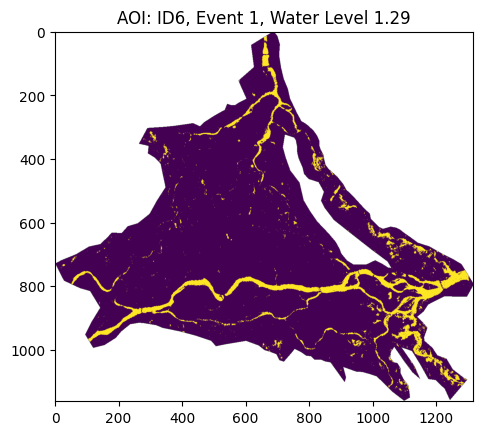

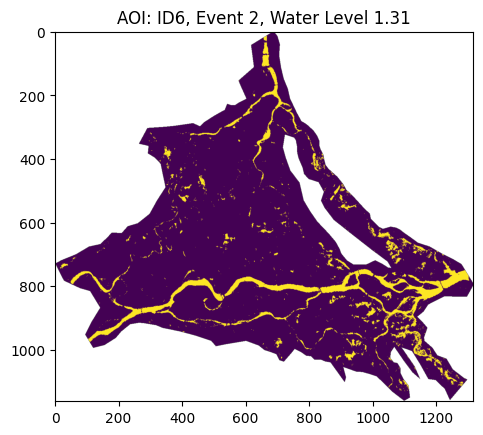

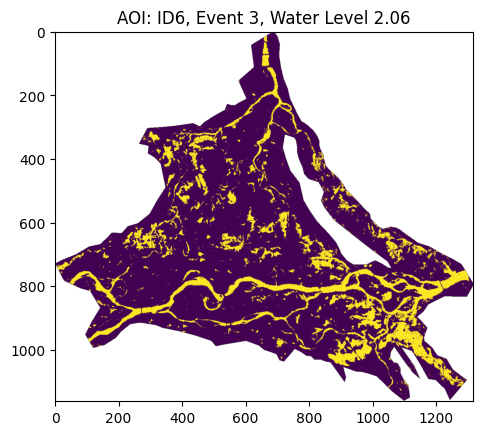

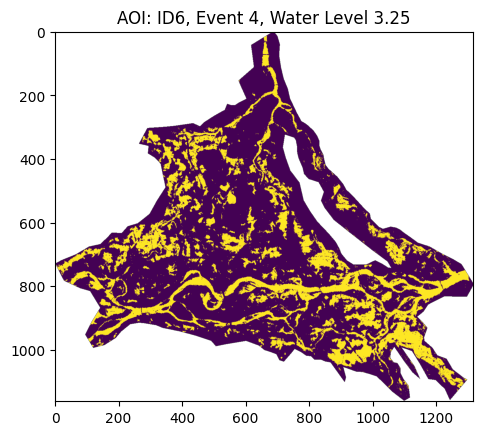

In [6]:
for aoi in results_per_aoi:
    for nr, gt in enumerate(GROUND_TRUTH_per_aoi[aoi]):
        plt.imshow(gt.ground_truth)
        plt.title(f"AOI: {aoi}, Event {nr+1}, Water Level {gt.gauge_measurement}")
        plt.show()

In [7]:
# MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
MIN_RATIOS = [0.5, 1]

trained_models_tm= {}

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Number of ground truth images: {len(GROUND_TRUTH)}")
    print(f"Using minimum ratios: {MIN_RATIOS}")
    
    tm = ThresholdingModel()
    
    tm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=GROUND_TRUTH
    )
    
    trained_models_tm[aoi_name] = tm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)


Starting training for AOI: ID6
Number of ground truth images: 4
Using minimum ratios: [0.5, 1]


C:\Users\jong\Projects\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\jong\Projects\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.5 we get f1=0.9615551717575752
For min_ratio=1 we get f1=0.9651129127404915
chosen min_ratio 1
Finished training for AOI: ID6


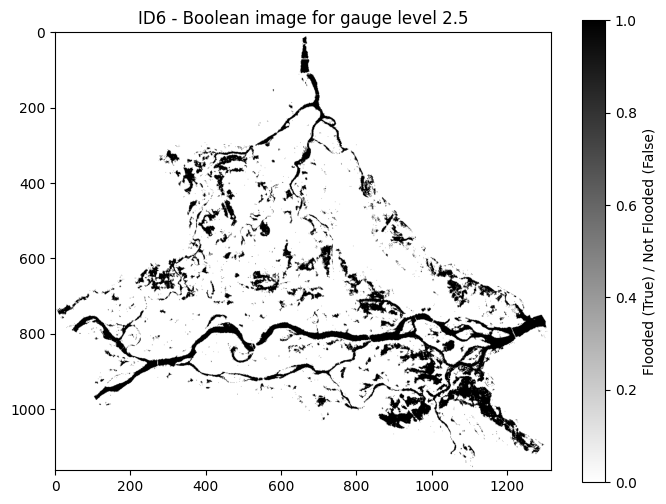

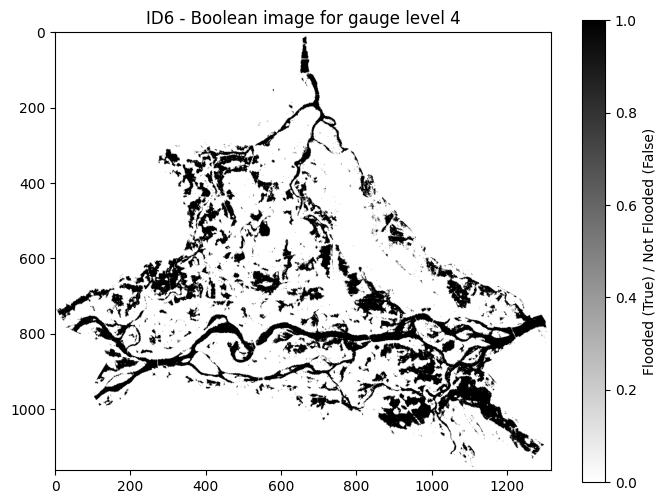

In [10]:
# Example gauge levels to test
gauge_levels = [2.5, 4]

# Loop over all AOIs and trained models
for aoi_name, tm in trained_models_tm.items():
    for gauge_level in gauge_levels:
        plt.figure(figsize=(8, 6))
        plt.title(f'{aoi_name} - Boolean image for gauge level {gauge_level}')
        plt.imshow(tm.infer(gauge_level), cmap='binary')  # Boolean images are usually better in gray
        plt.colorbar(label='Flooded (True) / Not Flooded (False)')
        plt.show()

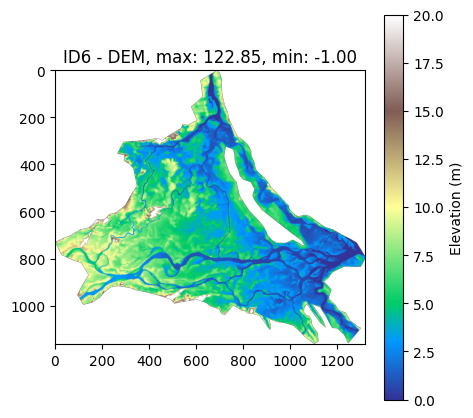

In [11]:
DEM_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    if aoi_file.split('_')[1].split('.')[0] == "Modrica":  # skip for now
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Clip DEM for this AOI
    DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
    
    # Store in a dictionary
    DEM_per_aoi[aoi_name] = {
        'DEM': DEM,
        'transform': dem_transform,
        'crs': dem_crs
    }
    
    # Optional: quick visualization
    plt.figure(figsize=(5, 5))
    plt.title(f'{aoi_name} - DEM, max: {np.nanmax(DEM):.2f}, min: {np.nanmin(DEM):.2f}')
    plt.imshow(DEM, cmap='terrain', vmin=0, vmax=20)
    plt.colorbar(label='Elevation (m)')
    plt.show()

In [12]:
from eo_flood_ops.model_utils import flood_extent_to_depth_solve, LaplaceDepthSolverConfig
from eo_flood_ops.manifold_model import ManifoldModel

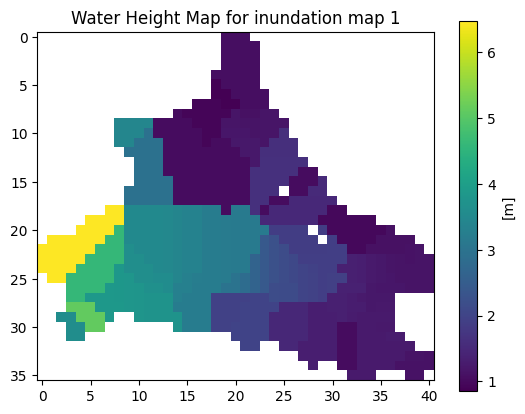

In [13]:
#@title Plot flood extent to depth output
height_raster = flood_extent_to_depth_solve(
    inundation_map=GROUND_TRUTH_per_aoi["ID6"][0].ground_truth, 
    dem=DEM_per_aoi["ID6"]['DEM'], 
    scale=30, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=32, 
        solve_iterations_factor=3.,
        force_coeff=0.1,
        drop_iterations=2,
        drop_coeff=0.1),
    force_tolerance=1, 
    force_local_region_width=5)

plt.title('Water Height Map for inundation map 1')
plt.imshow(height_raster)
plt.colorbar(label='[m]')
plt.show()

In [14]:
trained_models_mm = {}
MIN_RATIOS = [0.5, 1]

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Number of ground truth images: {len(GROUND_TRUTH)}")
    print(f"Using minimum ratios: {MIN_RATIOS}")

    # Get DEM for this AOI
    DEM = DEM_per_aoi[aoi_name]['DEM']

    # Create the model
    mm = ManifoldModel(
        dem=DEM,
        scale=30,
        laplace_config=LaplaceDepthSolverConfig(
            down_scale_factor=32,
            solve_iterations_factor=3.,
            force_coeff=0.9,
            drop_iterations=1,
            drop_coeff=0.00003
        ),
        force_tolerance=1,
        force_local_region_width=5,
        flood_agree_threshold=0.1
    )

    mm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=GROUND_TRUTH
    )

    trained_models_mm[aoi_name] = mm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)


Starting training for AOI: ID6
Number of ground truth images: 4
Using minimum ratios: [0.5, 1]
Training an inner thresholding model used for flood-fill.


C:\Users\jong\Projects\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\jong\Projects\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.5 we get f1=0.9615551717575752
For min_ratio=1 we get f1=0.9651129127404915
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 1.29
Running flood extent to depth algorithm for image at gauge_level 1.31
Running flood extent to depth algorithm for image at gauge_level 2.06
Running flood extent to depth algorithm for image at gauge_level 3.25
Finished training for AOI: ID6


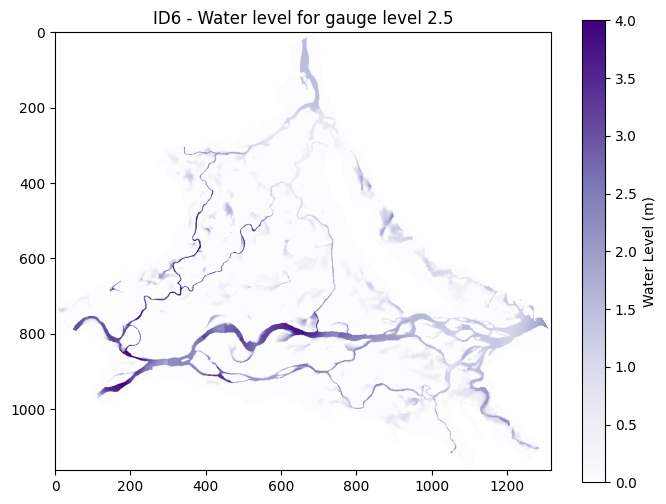

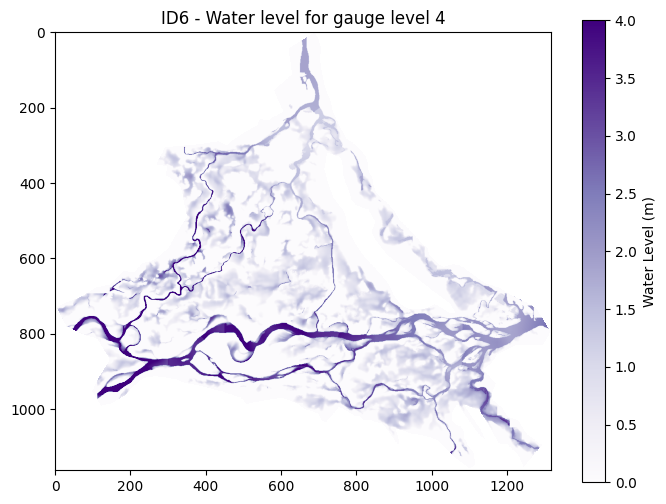

In [13]:
# Example gauge levels to test
gauge_levels = [2.5, 4]

# Loop over all AOIs and trained models
for aoi_name, tm in trained_models_mm.items():
    for gauge_level in gauge_levels:
        # plot the region as well
        plt.figure(figsize=(8, 6))
        plt.title(f'{aoi_name} - Water level for gauge level {gauge_level}')
        plt.imshow(tm.infer(gauge_level), cmap='Purples', vmin=0, vmax=4)  # Adjust vmin and vmax as needed
        plt.colorbar(label='Water Level (m)')
        plt.show()

In [15]:
gauge_levels = [2.5, 4]
timestamps = pd.date_range("2020-01-01", periods=len(gauge_levels), freq="7D")

ds_per_aoi = {}  # dict to store datasets

for aoi_name, trained_model in trained_models_mm.items():    
    transform = DEM_per_aoi[aoi_name]['transform']
    crs = DEM_per_aoi[aoi_name]['crs']

    # Generate the Dataset for this AOI
    ds_man = generate_wet_dry_timeseries_ds(
        water_levels=gauge_levels,
        timestamps=timestamps,
        tm=trained_model,
        transform=transform,
        crs=crs
    )

    # Store in the dictionary
    ds_per_aoi[aoi_name] = ds_man

AttributeError: 'Dataset' object has no attribute 'raster'

In [ ]:
import geopandas as gpd  # noqa: E402

In [ ]:
region = gpd.read_file(R"p:\11211461-010--eo-flood-ops\HoiAn\AOI\AOI_ID6.geojson")

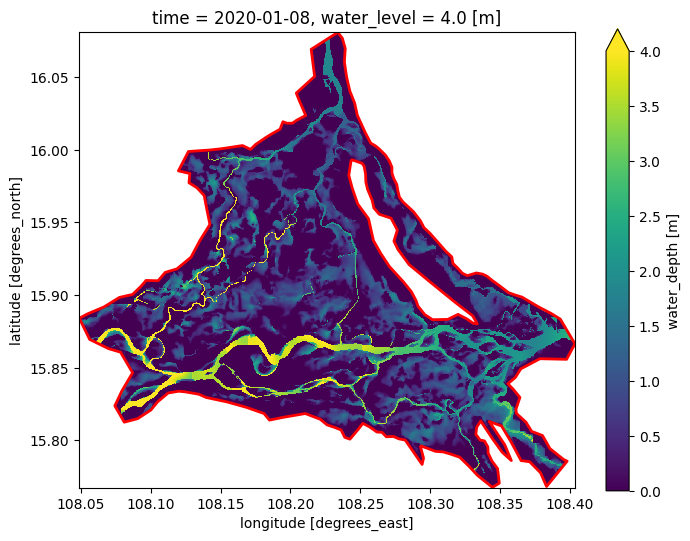

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
# add the region boundary
region.boundary.plot(ax=ax, color='red', linewidth=2)
ds_per_aoi["ID6"]["water_depth"].sel(time="2020-01-8").plot(cmap="viridis", vmin=0, vmax=4, ax=ax)

In [33]:
tt = ds_per_aoi["ID6"]["water_depth"].sel(time="2020-01-8") > 0.2

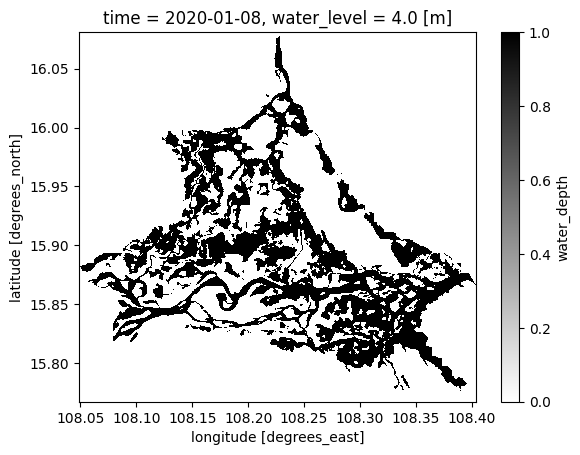

In [34]:
tt.plot(cmap="binary")